## Import & chargement des données

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Options d'affichage
pd.set_option("display.max_columns", None)
plt.style.use("default")

# Chargement du dataset
df = pd.read_excel("E_i.xlsx", parse_dates=["Date"])

print(df.shape)
df.head()


(1048575, 13)


,ID,Date,Prelibt,CIP,DOSE,dosage,Freq,Durée,DCI,ATC,is_ARV,classe_th,E_I
0,1,2004-04-14,BACTRIM cp Ad,3001069,1 Comprimé,400 mg; 80 mg,1 fois / jour,30 jour(s),SULFAMETHOXAZOLE; TRIMETHOPRIME,NaN,0,NaN,NaN
1,1,2004-04-14,KALETRA caps,3566794,3 Capsule,200 mg; 50 mg,Toutes les 12 heures,30 jour(s),LOPINAVIR; RITONAVIR,J05AR10,1,2 IP,NaN
2,1,2004-04-14,COMBIVIR cp enrobé,3466271,1 Comprimé,150 mg; 300 mg,Toutes les 12 heures,30 jour(s),LAMIVUDINE; ZIDOVUDINE,J05AR01,1,2 INTI,NaN
3,2,2013-10-01,TRUVADA 200MG/245MG CPR 30,3656563,1 comprimé,200 mg; 300 mg,par jour,1 mois,EMTRICITABINE; MALEATE DE TENOFOVIR DISOPROXIL,J05AR03,1,2 INTI,NaN
4,2,2013-10-01,ISENTRESS 400MG CPR 60,3830848,2 comprimés,"434,4 mg",par jour,1 mois,RALTEGRAVIR,J05AJ01,1,INI,NaN


## Création des entités clés

### 1.1 Visite médicale = (ID, Date)

In [14]:
df["visite_id"] = df["ID"].astype(str) + "_" + df["Date"].astype(str)


### 1.2 Vérification rapide

In [15]:
df[["ID", "Date", "visite_id"]].head()


,ID,Date,visite_id
0,1,2004-04-14,1_2004-04-14
1,1,2004-04-14,1_2004-04-14
2,1,2004-04-14,1_2004-04-14
3,2,2013-10-01,2_2013-10-01
4,2,2013-10-01,2_2013-10-01


## Analyses descriptives globales

### 2.1 Volumes globaux

In [10]:
nb_patients = df["ID"].nunique()
nb_visites = df["visite_id"].nunique()
nb_prescriptions = len(df)
nb_medicaments = df["CIP"].nunique()

summary = pd.DataFrame({
    "Indicateur": ["Patients", "Visites", "Prescriptions", "Médicaments distincts"],
    "Valeur": [nb_patients, nb_visites, nb_prescriptions, nb_medicaments]
})

summary


,Indicateur,Valeur
0,Patients,12859
1,Visites,237967
2,Prescriptions,1048575
3,Médicaments distincts,11595


### 2.2 Nombre de prescriptions par patient

In [16]:
presc_per_patient

ID
1            3
2           46
3            5
4          507
5           23
          ... 
600000      12
700000      14
800000      79
900000      13
1000000      4
Length: 12859, dtype: int64

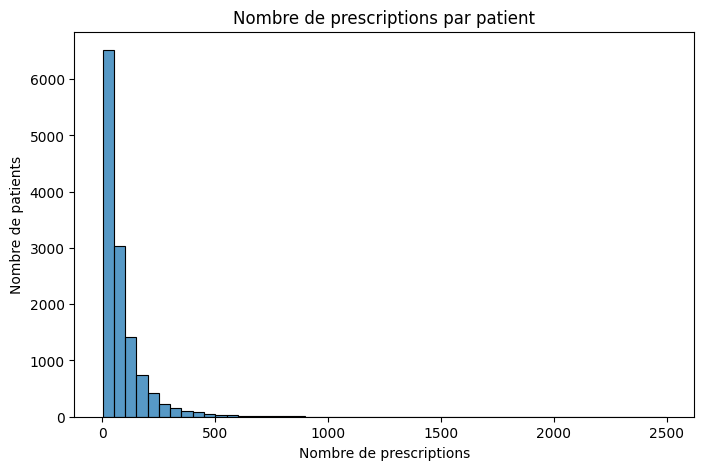

In [15]:
presc_per_patient = df.groupby("ID").size()

plt.figure(figsize=(8,5))
sns.histplot(presc_per_patient, bins=50)
plt.title("Nombre de prescriptions par patient")
plt.xlabel("Nombre de prescriptions")
plt.ylabel("Nombre de patients")
plt.show()


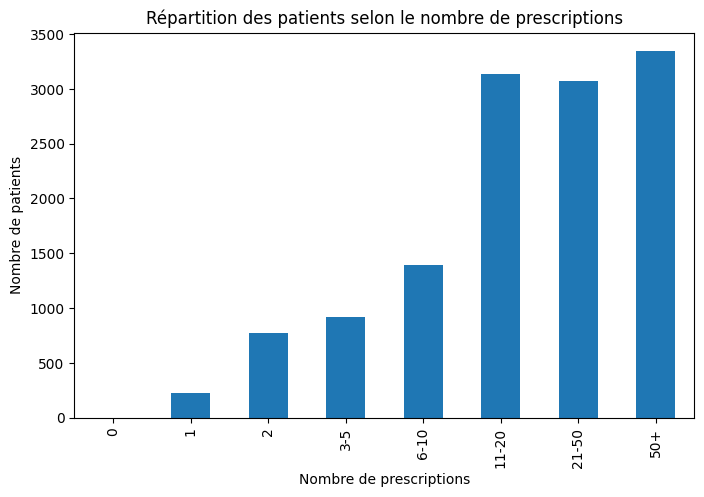

In [17]:
bins = [0, 1, 2, 5, 10, 20, 50, 100, presc_per_patient.max()]
labels = ["0", "1", "2", "3-5", "6-10", "11-20", "21-50", "50+"]

presc_bins = pd.cut(presc_per_patient, bins=bins, labels=labels, right=False)

presc_bins.value_counts().sort_index().plot(kind="bar", figsize=(8,5))
plt.title("Répartition des patients selon le nombre de prescriptions")
plt.xlabel("Nombre de prescriptions")
plt.ylabel("Nombre de patients")
plt.show()


## Poly-prescription (médicaments par visite)

In [19]:
meds_per_visite = df.groupby("visite_id").size()

meds_per_visite.describe()


count    237967.000000
mean          4.406388
std           3.235265
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          38.000000
dtype: float64

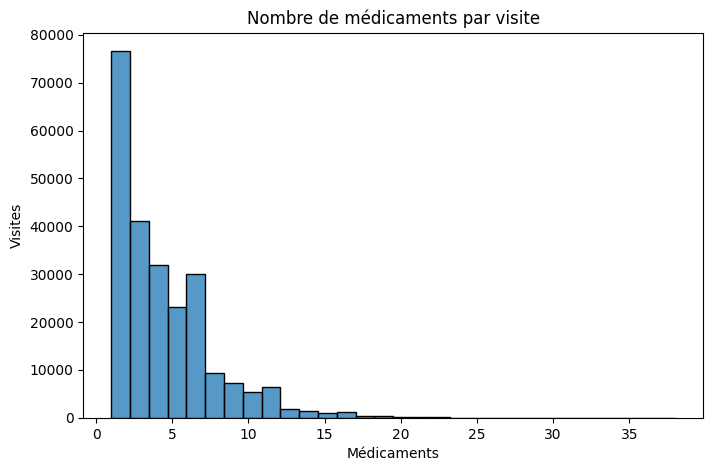

In [20]:
plt.figure(figsize=(8,5))
sns.histplot(meds_per_visite, bins=30)
plt.title("Nombre de médicaments par visite")
plt.xlabel("Médicaments")
plt.ylabel("Visites")
plt.show()


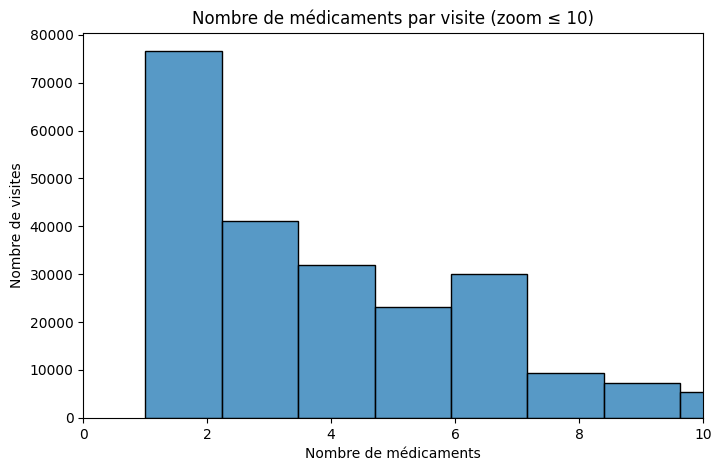

In [24]:
plt.figure(figsize=(8,5))
sns.histplot(meds_per_visite, bins=30)
plt.xlim(0, 10)
plt.title("Nombre de médicaments par visite (zoom ≤ 10)")
plt.xlabel("Nombre de médicaments")
plt.ylabel("Nombre de visites")
plt.show()


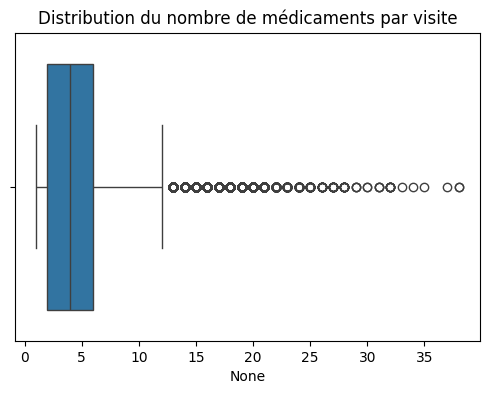

In [21]:
plt.figure(figsize=(6,4))
sns.boxplot(x=meds_per_visite)
plt.title("Distribution du nombre de médicaments par visite")
plt.show()


## Médicaments les plus prescrits

### 4.1 Top médicaments (nom commercial)

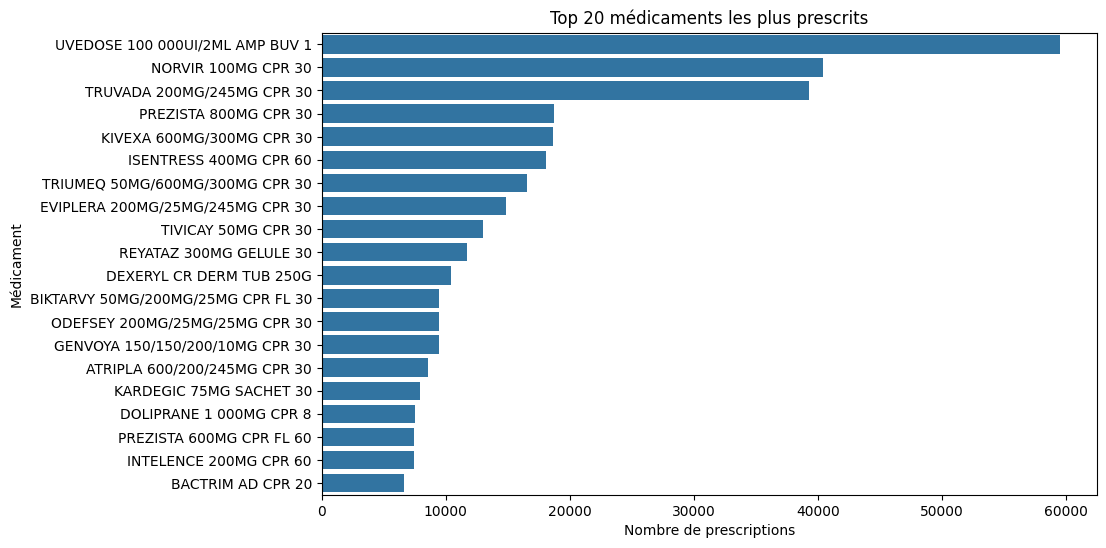

In [25]:
top_meds = df["Prelibt"].value_counts().head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=top_meds.values, y=top_meds.index)
plt.title("Top 20 médicaments les plus prescrits")
plt.xlabel("Nombre de prescriptions")
plt.ylabel("Médicament")
plt.show()


### 4.2 Top DCI

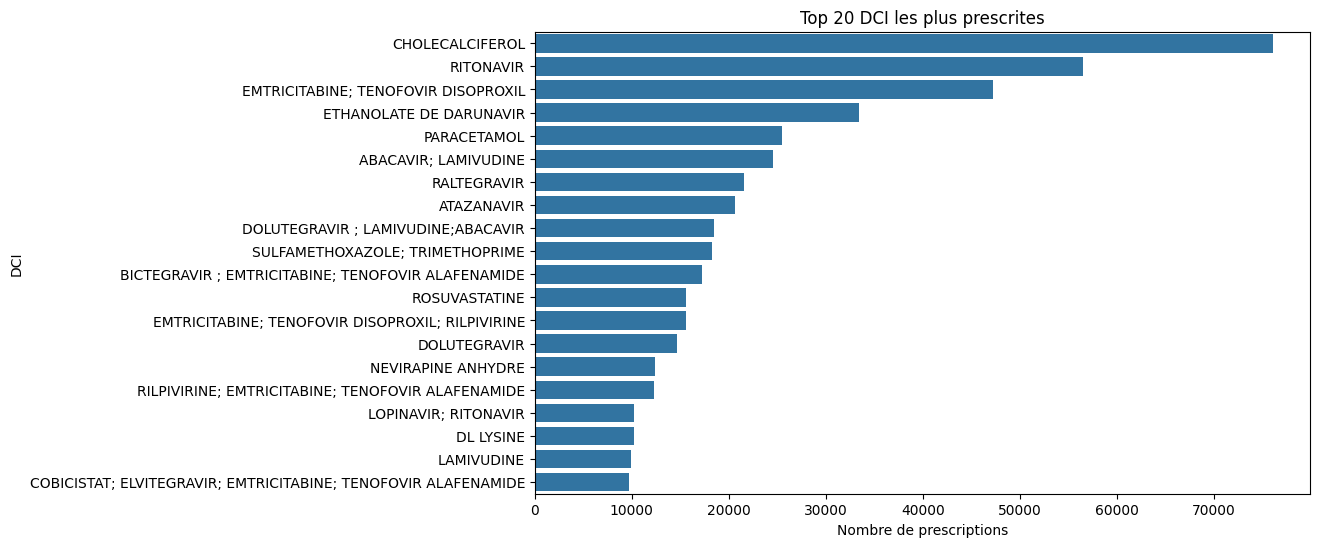

In [26]:
top_dci = df["DCI"].value_counts().head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=top_dci.values, y=top_dci.index)
plt.title("Top 20 DCI les plus prescrites")
plt.xlabel("Nombre de prescriptions")
plt.ylabel("DCI")
plt.show()


## ARV vs non-ARV

### 5.1 Proportions

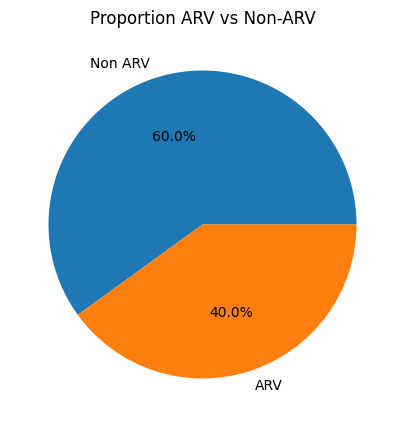

In [27]:
arv_counts = df["is_ARV"].value_counts().rename({0: "Non ARV", 1: "ARV"})

plt.figure(figsize=(5,5))
arv_counts.plot(kind="pie", autopct="%1.1f%%")
plt.title("Proportion ARV vs Non-ARV")
plt.ylabel("")
plt.show()


### 5.2 Évolution ARV dans le temps

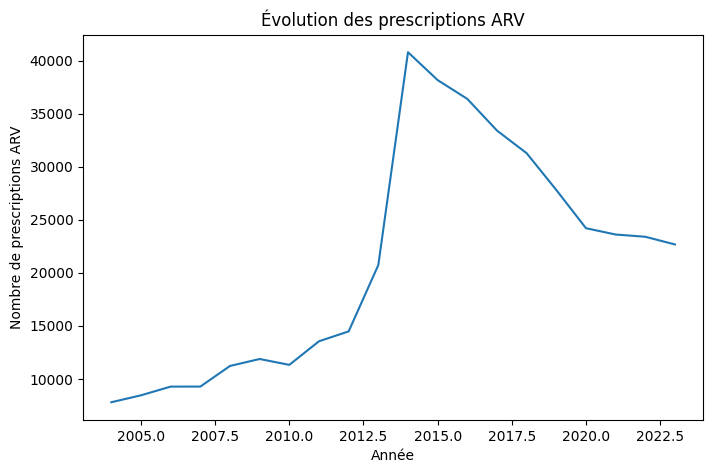

In [28]:
df["year"] = df["Date"].dt.year

arv_time = df[df["is_ARV"] == 1].groupby("year").size()

plt.figure(figsize=(8,5))
arv_time.plot()
plt.title("Évolution des prescriptions ARV")
plt.xlabel("Année")
plt.ylabel("Nombre de prescriptions ARV")
plt.show()


## Analyses spécifiques ARV

### 6.1 Répartition des classes thérapeutiques

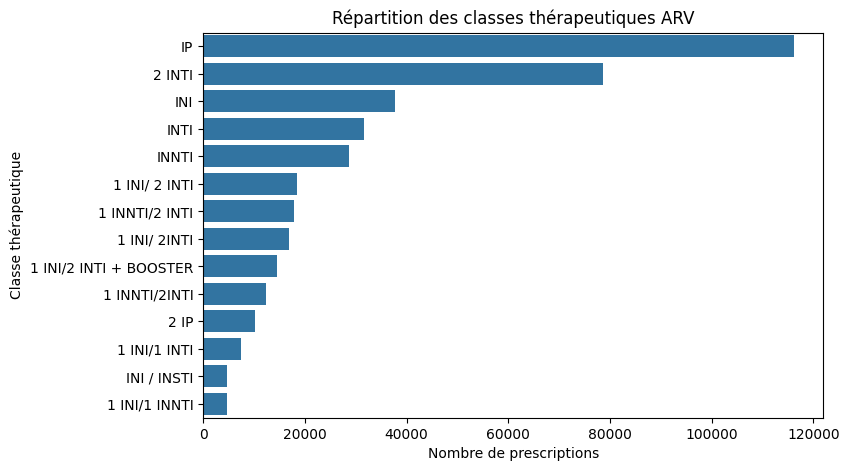

In [29]:
arv_df = df[df["is_ARV"] == 1]

classe_counts = arv_df["classe_th"].value_counts()

plt.figure(figsize=(8,5))
sns.barplot(x=classe_counts.values, y=classe_counts.index)
plt.title("Répartition des classes thérapeutiques ARV")
plt.xlabel("Nombre de prescriptions")
plt.ylabel("Classe thérapeutique")
plt.show()


### 6.2 Nombre d’ARV par visite

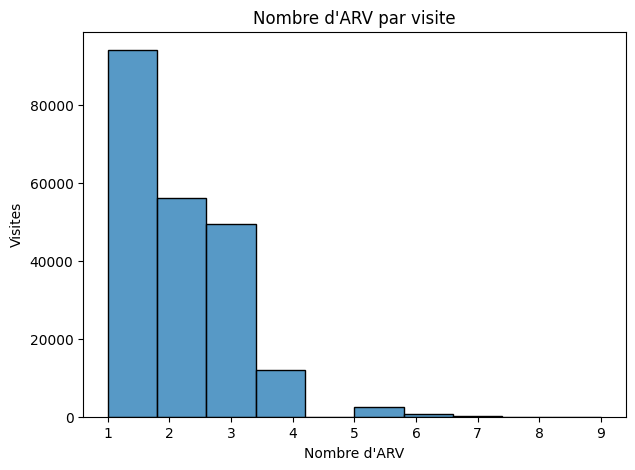

In [30]:
arv_per_visite = arv_df.groupby("visite_id").size()

plt.figure(figsize=(7,5))
sns.histplot(arv_per_visite, bins=10)
plt.title("Nombre d'ARV par visite")
plt.xlabel("Nombre d'ARV")
plt.ylabel("Visites")
plt.show()


### 6.3 Co-prescription des classes ARV (heatmap)

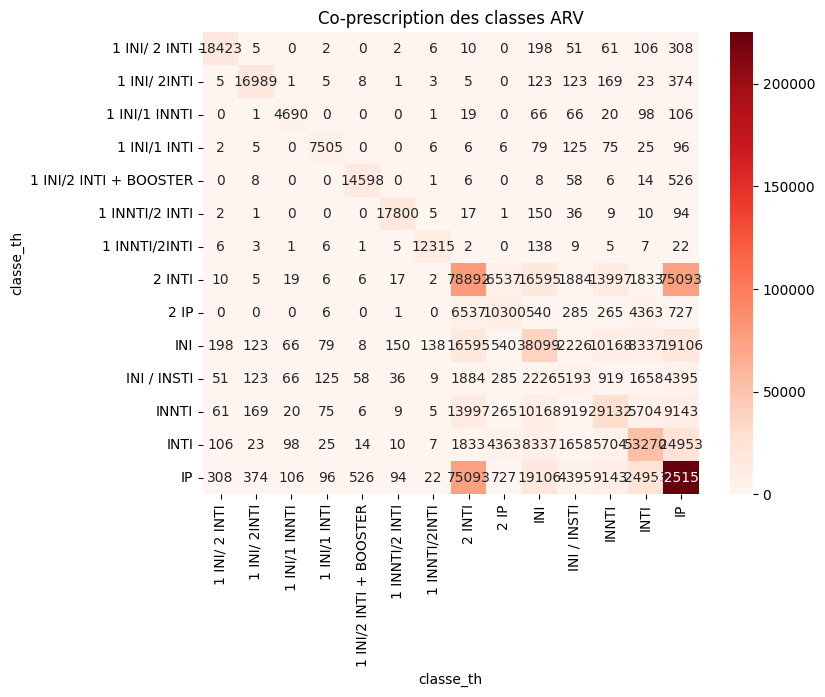

In [35]:
# Création matrice visite x classe
arv_matrix = (
    arv_df
    .dropna(subset=["classe_th"])
    .pivot_table(index="visite_id", columns="classe_th", aggfunc="size", fill_value=0)
)

co_prescription = arv_matrix.T.dot(arv_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(co_prescription, annot=True, fmt="d", cmap="Reds")
plt.title("Co-prescription des classes ARV")
plt.show()


## Effets indésirables (E_I)

### 7.1 Taux de valeurs manquantes

In [36]:
ei_missing = df["E_I"].isna().mean() * 100
ei_missing


88.96578690127077

### 7.2 Médicaments avec EI renseignés

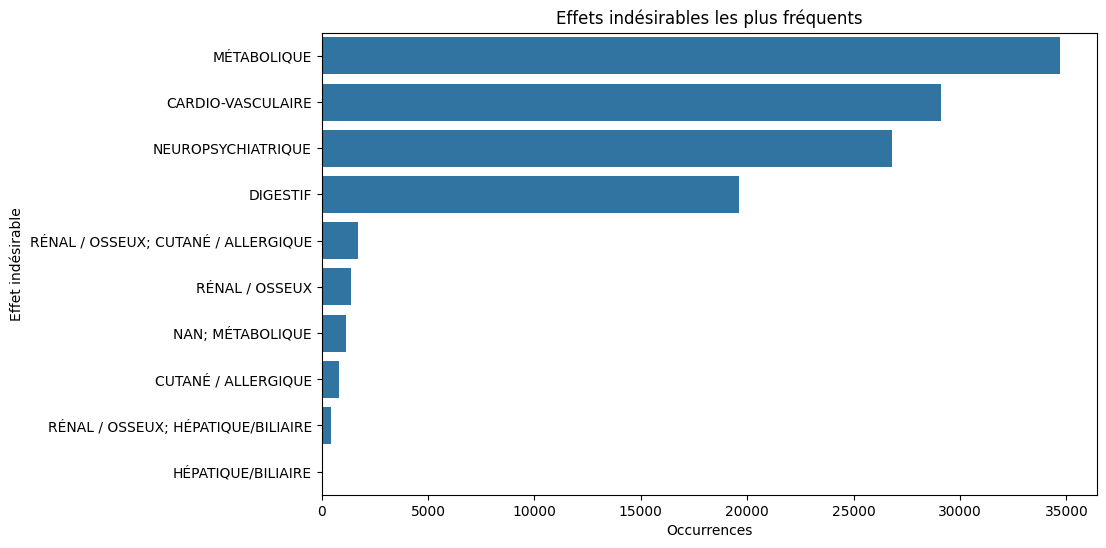

In [37]:
ei_df = df.dropna(subset=["E_I"])

top_ei = ei_df["E_I"].value_counts().head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top_ei.values, y=top_ei.index)
plt.title("Effets indésirables les plus fréquents")
plt.xlabel("Occurrences")
plt.ylabel("Effet indésirable")
plt.show()


## Parcours patient (longitudinal)

### 8.1 Nombre de visites par patient

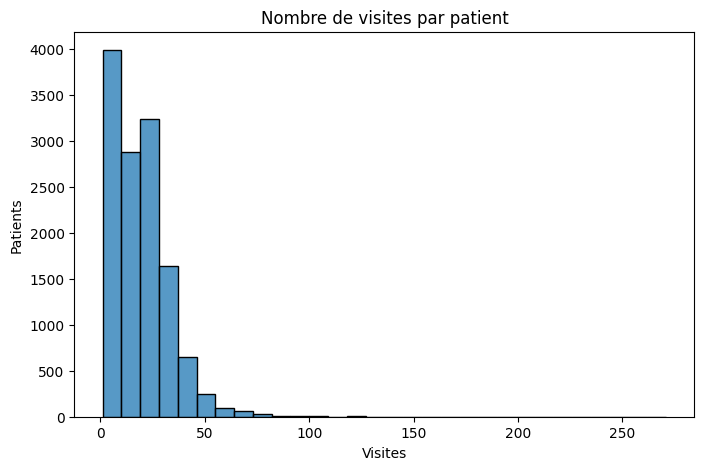

In [38]:
visites_per_patient = df.groupby("ID")["visite_id"].nunique()

plt.figure(figsize=(8,5))
sns.histplot(visites_per_patient, bins=30)
plt.title("Nombre de visites par patient")
plt.xlabel("Visites")
plt.ylabel("Patients")
plt.show()


### 8.2 Exemple timeline patient

In [39]:
example_patient = df["ID"].value_counts().index[0]

timeline = (
    df[df["ID"] == example_patient]
    .sort_values("Date")[["Date", "Prelibt", "is_ARV"]]
)

timeline.head(10)


,Date,Prelibt,is_ARV
727941,2013-12-20,"SEBIPROX 1,5% SHAMP 100ML",0
727942,2013-12-20,DEXERYL CR DERM TUB 250G,0
727943,2013-12-20,"DERMOVAL 0,05% CR TUB 10G",0
727944,2013-12-20,AMYCOR 1% CR TUB 15G,0
727956,2013-12-23,INTELENCE 200MG CPR 60,1
727955,2013-12-23,LYRICA 100MG GELULE 84,0
727954,2013-12-23,"LOCOID 0,1% LOT 30ML",0
727953,2013-12-23,ZELITREX cp enrobé 500 mg,1
727951,2013-12-23,SERESTA 50MG CPR SECABLE 20,0
727952,2013-12-23,INEXIUM 40MG CPR 28,0


## Indicateurs simples d’alerte (Octavia)

### 9.1 Visites à forte poly-médication

In [40]:
alert_visites = meds_per_visite[meds_per_visite >= 5]

len(alert_visites)


88227

### 9.2 Visites ARV + médicaments non ARV

In [4]:
arv_non_arv_visite = (
    df.groupby("visite_id")["is_ARV"]
    .agg(["sum", "count"])
)

arv_non_arv_visite["non_ARV"] = arv_non_arv_visite["count"] - arv_non_arv_visite["sum"]

arv_non_arv_visite.head()


,sum,count,non_ARV
visite_id,,,
1000000_2018-04-26,2,2,0
1000000_2018-05-18,2,2,0
100000_2016-11-23,3,3,0
10001_2023-06-07,1,5,4
10001_2023-06-23,2,2,0


In [5]:
arv_non_arv_visite

,sum,count,non_ARV
visite_id,,,
1000000_2018-04-26,2,2,0
1000000_2018-05-18,2,2,0
100000_2016-11-23,3,3,0
10001_2023-06-07,1,5,4
10001_2023-06-23,2,2,0
...,...,...,...
9_2021-01-07,1,3,2
9_2021-06-24,1,3,2
9_2022-03-10,1,3,2


# partie 2 

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx


In [19]:
# On se concentre sur les médicaments non-ARV pour les EI
ei_df = df[(df["is_ARV"] == 0) & (df["E_I"].notna())]

# Normaliser les effets indésirables : parfois plusieurs effets dans la même cellule
ei_df["E_I_list"] = ei_df["E_I"].str.split(";|,")  # séparer par ; ou , si plusieurs EI
ei_df = ei_df.explode("E_I_list")
ei_df["E_I_list"] = ei_df["E_I_list"].str.strip().str.lower()  # nettoyage


C:\Users\toufi\AppData\Local\Temp\ipykernel_19020\219405454.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ei_df["E_I_list"] = ei_df["E_I"].str.split(";|,")  # séparer par ; ou , si plusieurs EI


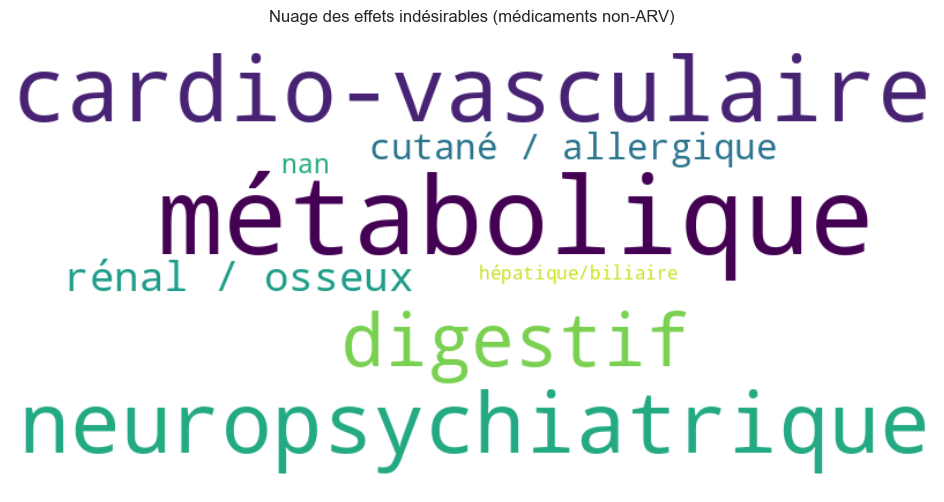

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# Fréquence des effets indésirables
ei_freq = ei_df["E_I_list"].value_counts().to_dict()  # important: .to_dict()

# Génération du WordCloud
wc = WordCloud(width=800, height=400, background_color='white')
wc.generate_from_frequencies(ei_freq)

# Conversion en image compatible matplotlib (contourne le bug NumPy 2.x)
wc_array = np.array(wc.to_image())  # PAS de copy ici

# Affichage
plt.figure(figsize=(12,6))
plt.imshow(wc_array, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage des effets indésirables (médicaments non-ARV)")
plt.show()


In [20]:
# On garde uniquement ARV et les EI associés à la même visite
arv_visite = df[df["is_ARV"] == 1][["visite_id","classe_th"]].dropna()
ei_visite = ei_df[["visite_id","E_I_list"]]

# Merge sur la visite
merged = arv_visite.merge(ei_visite, on="visite_id", how="inner")
merged.head()


,visite_id,classe_th,E_I_list
0,2_2021-09-13,1 INI/ 2INTI,neuropsychiatrique
1,2_2022-06-13,1 INI/ 2INTI,neuropsychiatrique
2,3_2023-11-06,1 INI/1 INNTI,métabolique
3,3_2023-11-06,1 INI/1 INNTI,métabolique
4,4_2009-05-12,IP,digestif


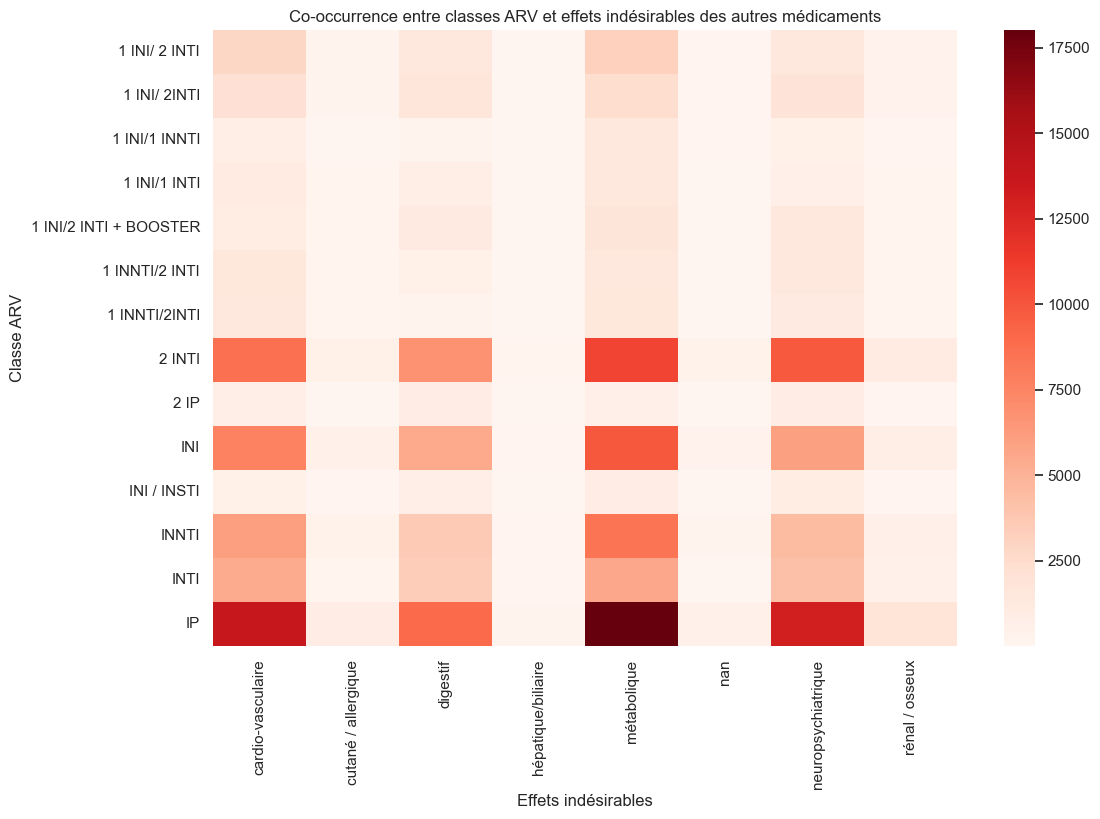

In [21]:
co_matrix = pd.crosstab(merged["classe_th"], merged["E_I_list"])

plt.figure(figsize=(12,8))
sns.heatmap(co_matrix, cmap="Reds", annot=False)
plt.title("Co-occurrence entre classes ARV et effets indésirables des autres médicaments")
plt.xlabel("Effets indésirables")
plt.ylabel("Classe ARV")
plt.show()


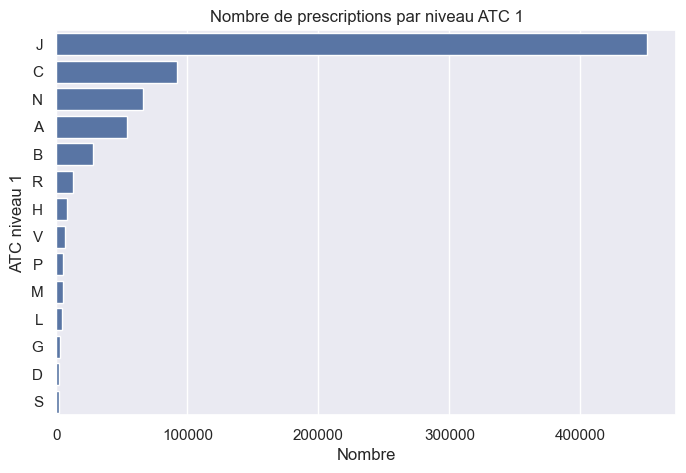

In [29]:
atc_counts = df.groupby("ATC_lvl1").size().sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=atc_counts.values, y=atc_counts.index)
plt.title("Nombre de prescriptions par niveau ATC 1")
plt.xlabel("Nombre")
plt.ylabel("ATC niveau 1")
plt.show()
